In [1]:
# The code is a demo simulation of IDtree model
# Detail about model see:
# Jin, K.-Y., Wu, Y.-J., & Chen, H.-F. (2022). A New Multiprocess IRT Model With Ideal Points for Likert-Type Items. 
# Journal of Educational and Behavioral Statistics, 47(3), 297–321. https://doi.org/10.3102/10769986211057160

# Include:
# 1. data generation
# 2. parameter estimation
# 3. model check and recovery indicator calculation


In [26]:

import numpy as np
import jax
from jax import nn, random, vmap
import jax.numpy as jnp
import pandas as pd
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, DiscreteHMCGibbs, MixedHMC, HMC
from numpyro.distributions import constraints, transforms
import arviz as az
numpyro.set_host_device_count(32)
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
numpyro.enable_x64()

sns.set_theme(style="white")

In [3]:
def categorical(p):
    return (p.cumsum(-1) >= np.random.uniform(size=p.shape[:-1])[..., None]).argmax(-1)

# Data Generation

In [4]:
N = 100
I = 20

In [5]:
# array_shape = (person, item, score_p)
# person param generation
cov = [[1, 0.6], [0.6, 1]]
mean = [0, 0]
person_param = np.random.multivariate_normal(mean, cov, N)
theta = person_param[:, 0].reshape(-1, 1, 1)
eta = person_param[:, 1].reshape(-1, 1, 1)


In [6]:

# item param generation
alpha = np.random.uniform(0.5, 2.5, (1,I,1))
delta = np.random.uniform(-2, 2, (1,I,1))
tau = np.random.uniform((-2.5, -1.5), (-1.5, -0.5), size=(1,I,2))
beta = np.random.uniform(0.5, 2.5, (1,I,1))
xi = np.random.uniform((-1, 0), (0, 1), size=(1,I,2))


In [7]:

# response generation
## process 1
num_p1 = np.concatenate([np.ones((N,I,1)), # num_p1_1
                         np.exp(alpha * 1 * (theta - delta) - tau[:,:,[0]]), # num_p1_2
                         np.exp(alpha * 2 * (theta - delta) - tau[:,:,[0]] - tau[:,:,[1]]), # num_p1_3
                         np.exp(alpha * 3 * (theta - delta) - tau[:,:,[0]] - tau[:,:,[1]]), # num_p1_4
                         np.exp(alpha * 4 * (theta - delta) - tau[:,:,[0]]), # num_p1_5
                         np.exp(alpha * 5 * (theta - delta))], # num_p1_6
                         axis=-1)


p1_prob_1 = num_p1[:,:,[0,5]].sum(axis=-1)/num_p1.sum(axis=-1) # disagree
p1_prob_2 = num_p1[:,:,[1,4]].sum(axis=-1)/num_p1.sum(axis=-1) # neutral
p1_prob_3 = num_p1[:,:,[2,3]].sum(axis=-1)/num_p1.sum(axis=-1) # agree
p1_prob = np.stack([p1_prob_1, p1_prob_2, p1_prob_3],axis=-1)

In [8]:
## process 2 
logit_p2_prob = beta * (eta-xi)
p2_prob = np.exp(logit_p2_prob) / (1+np.exp(logit_p2_prob))
p2_prob = np.pad(p2_prob,[(0,0), (0,0), (1,1)], constant_values=(1,0))
p2_prob = np.stack([p2_prob[:,:,i]-p2_prob[:,:,i+1] for i in range(3)],axis=-1)

prob = np.stack([p1_prob[:,:,0]*p2_prob[:,:,2], # strong disagree
                 p1_prob[:,:,0]*p2_prob[:,:,1], # disagree
                 p1_prob[:,:,1] + p1_prob[:,:,0]*p2_prob[:,:,0] + p1_prob[:,:,2]*p2_prob[:,:,0], # neutral
                 p1_prob[:,:,2]*p2_prob[:,:,1], # agree
                 p1_prob[:,:,2]*p2_prob[:,:,2]], # strong agree
                 axis=-1)
Y = categorical(prob)

# Parameter Estimation

In [9]:
# with numpyro.handlers.seed(rng_seed=0):
# define a numpyro model
def IDtree():
    person_plate = numpyro.plate("person_plate", N, dim=-2)
    item_plate = numpyro.plate("item_plate", I, dim=-1)
    
    # prior for person 
    ## corr_matrix 
    corr_cholesky_L = numpyro.sample("corr_cholesky_L", dist.LKJCholesky(2, 1))
    corr = numpyro.deterministic("corr", corr_cholesky_L.dot(corr_cholesky_L.T))
    stds = jnp.ones(2)
    
    with person_plate:
        person_param_raw = numpyro.sample("person_param_raw", dist.Normal(jnp.zeros(2), 1).to_event(1))
        person_param = numpyro.deterministic("person_param",jnp.diag(stds).dot(corr_cholesky_L).dot(person_param_raw.squeeze().T))
        theta = numpyro.deterministic("theta", person_param[0].reshape(-1, 1, 1))
        eta = numpyro.deterministic("eta", person_param[1].reshape(-1, 1, 1))

    # prior for item
    with item_plate:
        alpha = numpyro.sample("alpha", dist.LogNormal(0, 0.5)).reshape(1, I, 1)
        delta = numpyro.sample("delta", dist.Normal(0, 2)).reshape(1, I, 1)
        tau = numpyro.sample("tau", dist.TransformedDistribution(
                    dist.Normal(jnp.array([-2,-1]), 2).to_event(1),
                    transforms.OrderedTransform()
                    ),
                            ).reshape(1, I, -1)


        beta = numpyro.sample("beta", dist.LogNormal(0, 0.5)).reshape(1, I, 1)
        xi = numpyro.sample("xi", dist.TransformedDistribution(
                    dist.Normal(jnp.array([-2,-1]), 2).to_event(1),
                    transforms.OrderedTransform()
                    ),
                            ).reshape(1, I, -1)

        
    # process 1
    num_p1 = jnp.concatenate([jnp.ones((N,I,1)), # num_p1_1
                             jnp.exp(alpha * 1 * (theta - delta) - tau[:,:,[0]]), # num_p1_2
                             jnp.exp(alpha * 2 * (theta - delta) - tau[:,:,[0]] - tau[:,:,[1]]), # num_p1_3
                             jnp.exp(alpha * 3 * (theta - delta) - tau[:,:,[0]] - tau[:,:,[1]]), # num_p1_4
                             jnp.exp(alpha * 4 * (theta - delta) - tau[:,:,[0]]), # num_p1_5
                             jnp.exp(alpha * 5 * (theta - delta))], # num_p1_6
                             axis=-1)
    p1_prob_1 = num_p1[:,:,[0,5]].sum(axis=-1)/num_p1.sum(axis=-1) # disagree
    p1_prob_2 = num_p1[:,:,[1,4]].sum(axis=-1)/num_p1.sum(axis=-1) # neutral
    p1_prob_3 = num_p1[:,:,[2,3]].sum(axis=-1)/num_p1.sum(axis=-1) # agree
    p1_prob = jnp.stack([p1_prob_1, p1_prob_2, p1_prob_3],axis=-1)

    # process 2
    logit_p2_prob = beta * (eta-xi)
    p2_prob = jnp.exp(logit_p2_prob) / (1+jnp.exp(logit_p2_prob))
    p2_prob = jnp.pad(p2_prob,[(0,0), (0,0), (1,1)], constant_values=(1,0))
    p2_prob = jnp.stack([p2_prob[:,:,i]-p2_prob[:,:,i+1] for i in range(3)],axis=-1)

    prob = jnp.stack([p1_prob[:,:,0]*p2_prob[:,:,2], # strong disagree
                     p1_prob[:,:,0]*p2_prob[:,:,1], # disagree
                     p1_prob[:,:,1] + p1_prob[:,:,0]*p2_prob[:,:,0] + p1_prob[:,:,2]*p2_prob[:,:,0], # neutral
                     p1_prob[:,:,2]*p2_prob[:,:,1], # agree
                     p1_prob[:,:,2]*p2_prob[:,:,2]], # strong agree
                     axis=-1)
                     
    with person_plate:
        with item_plate:
            numpyro.deterministic("prob", prob)
            numpyro.sample("Y", dist.Categorical(logits=jax.scipy.special.logit(prob)), obs=Y)
            


In [10]:
kernel = NUTS(IDtree)
mcmc = MCMC(kernel, num_warmup=5000, 
            num_samples=2000,
            num_chains=2)
mcmc.run(random.PRNGKey(0))

pred = {"Y":categorical(mcmc.get_samples()["prob"])}
with numpyro.handlers.seed(rng_seed=1):
    idata = az.from_numpyro(
                        mcmc,
                        posterior_predictive=pred
                        )

Running chain 1: 100%|██████████| 7000/7000 [11:08<00:00, 10.47it/s]


# model Check And Recovery Indicator Calculation

## Convergence

In [11]:
rhat = az.rhat(idata)
rhat.mean()

<xarray.Dataset>
Dimensions:           ()
Data variables:
    alpha             float64 1.001
    beta              float64 1.0
    corr              float64 1.0
    corr_cholesky_L   float64 1.0
    delta             float64 1.001
    eta               float64 1.0
    person_param      float64 1.0
    person_param_raw  float64 1.0
    prob              float64 1.0
    tau               float64 1.001
    theta             float64 1.0
    xi                float64 1.001

In [12]:
# percent of rhat < 1.05
(1-(rhat>1.05)).mean()

<xarray.Dataset>
Dimensions:           ()
Data variables:
    alpha             float64 1.0
    beta              float64 1.0
    corr              float64 1.0
    corr_cholesky_L   float64 1.0
    delta             float64 1.0
    eta               float64 1.0
    person_param      float64 1.0
    person_param_raw  float64 1.0
    prob              float64 1.0
    tau               float64 1.0
    theta             float64 1.0
    xi                float64 1.0

## Model Fit

In [13]:
# WAIC
az.waic(idata, var_name="Y", scale="deviance")

Computed from 4000 posterior samples and 2000 observations log-likelihood matrix.

              Estimate       SE
deviance_waic  4490.60    80.99
p_waic          270.17        -

There has been a warning during the calculation. Please check the results.

In [14]:
# LOO
az.loo(idata, var_name="Y", scale="deviance")

Computed from 4000 posterior samples and 2000 observations log-likelihood matrix.

             Estimate       SE
deviance_loo  4505.08    81.48
p_loo          277.41        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1935   96.8%
 (0.5, 0.7]   (ok)         62    3.1%
   (0.7, 1]   (bad)         3    0.1%
   (1, Inf)   (very bad)    0    0.0%

In [15]:
# ppp
pred = idata["posterior_predictive"]["Y"].sum(axis=-2)
item_ppp = (Y.reshape(1,1,N,I).sum(axis=-2) > pred).mean(["chain", "draw"])
print("item_ppp",item_ppp.values.round(2))
print("ppp", (Y.reshape(1,1,N,I).sum(axis=-1).sum(axis=-1) > pred.sum(axis=-1)).mean(["chain", "draw"]).values.round(2))

item_ppp [0.5  0.29 0.35 0.38 0.25 0.58 0.49 0.52 0.44 0.36 0.27 0.48 0.58 0.49
 0.31 0.38 0.47 0.58 0.54 0.43]
ppp 0.29


## Revovery

Corr Matrix

In [27]:
# corr
print("corr", (idata.posterior["corr"].mean(["chain", "draw"])-cov).values)


corr [[ 0.         -0.07304857]
 [-0.07304857  0.        ]]


Person Parameter

In [28]:
# theta
print("Bias", (idata.posterior["theta"].mean(["chain", "draw"])-theta).mean().item())
print("ABSE", np.abs((idata.posterior["theta"].mean(["chain", "draw"])-theta)).mean().item())

Bias -0.03507954755042922
ABSE 0.3192935402238088


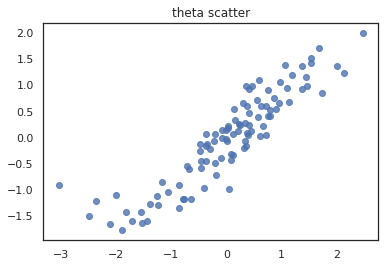

In [52]:
plt.scatter(theta, idata.posterior["theta"].mean(["chain", "draw"]),alpha=0.8)
plt.title("theta scatter")
plt.show()

In [53]:
# eta
print("Bias", (idata.posterior["eta"].mean(["chain", "draw"])-eta).mean().item())
print("ABSE", np.abs((idata.posterior["eta"].mean(["chain", "draw"])-eta)).mean().item())

Bias -0.12781559523896596
ABSE 0.3755297736590882


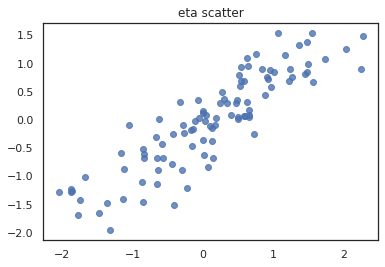

In [54]:
plt.scatter(eta, idata.posterior["eta"].mean(["chain", "draw"]),alpha=0.8)
plt.title("eta scatter")
plt.show()

Item Parameter

In [55]:
# alpha
print("Bias", (idata.posterior["alpha"].mean(["chain", "draw"])-alpha.squeeze()).mean().item())
print("ABSE", np.abs((idata.posterior["alpha"].mean(["chain", "draw"])-alpha.squeeze())).mean().item())

Bias -0.4106496417440672
ABSE 0.46459845299276087


In [56]:
# tau
print("Bias", (idata.posterior["tau"].mean(["chain", "draw"])-tau.squeeze()).mean().item())
print("ABSE", np.abs((idata.posterior["tau"].mean(["chain", "draw"])-tau.squeeze())).mean().item())

Bias 0.08243158058907436
ABSE 0.5146717818156328


In [57]:
# beta
print("Bias", (idata.posterior["beta"].mean(["chain", "draw"])-beta.squeeze()).mean().item())
print("ABSE", np.abs((idata.posterior["beta"].mean(["chain", "draw"])-beta.squeeze())).mean().item())

Bias -0.3103610815436379
ABSE 0.34647443741747597


In [58]:
# xi
print("Bias", (idata.posterior["xi"].mean(["chain", "draw"])-xi.squeeze()).mean().item())
print("ABSE", np.abs((idata.posterior["xi"].mean(["chain", "draw"])-xi.squeeze())).mean().item())

Bias -0.6384037125543962
ABSE 0.7147577903691968
